# Notebook for calculating Bispectrum
This notebook illustrates how to calculate the vanilla halo model bispectrum with this code

## Preparations

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
import camb

# Project imports
import pyhalomodel as halo

In [2]:
# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
As = 2e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # [eV]
sigma_8_set = True # If True uses the following value
sigma_8  = 0.8

# Wavenumber range [h/Mpc]
kmin, kmax = 1e-3, 100.
nk = 101
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshift
z = 0.

# Halo mass range [Msun/h] over which to integrate
Mmin, Mmax = 1e9, 1e17
nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# CAMB
zmax_CAMB = 2.
kmax_CAMB = 200.

# Plot colours
col_lin = 'grey'
col_mat = 'C0'
col_gal = 'C1'
col_mg  = 'C4'

# Plot line styles
ls_li = '-'
ls_hm = '-'
ls_2h = '--'
ls_1h = ':'

# Plot labels
klab = r'$k\,/\,h \mathrm{Mpc}^{-1}$'
Pklab = r'$P(k)/(h^{-1}\,\mathrm{Mpc})^3$'

## Calculate linear powerspectrum (with CAMB)

In [3]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()
wb = Omega_b*h**2
wc = Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=[z], kmax=kmax_CAMB) # Setup the linear matter power spectrum

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if sigma_8_set:
    camb_results = camb.get_results(pars)
    sigma_8_init = (camb_results.get_sigma8()[[z].index(0.)]).item()
    print('Initial sigma_8:', sigma_8_init)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Now get the linear power spectrum
Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear=False, 
                                            hubble_units=True, 
                                            k_hunit=True, 
                                            kmax=kmax_CAMB,
                                            var1=camb.model.Transfer_tot,
                                            var2=camb.model.Transfer_tot, 
                                            zmax=zmax_CAMB,
                                           )
Omega_m  = pars.omegam # Also extract the matter density
Pks_lin = Pk_lin.P(z, ks) # Single out the linear P(k) interpolator and evaluate linear power
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[[z].index(0.)]).item()
if sigma_8_set: print('Final sigma_8:', sigma_8)

Initial sigma_8: 0.8052480547740136
Final sigma_8: 0.7999999999999995


## Initialization of halo model and profile

In [4]:
# Initialise halo model
hmod = halo.model(z, Omega_m, name='Sheth & Tormen (1999)')
print(hmod)

Halo model: Sheth & Tormen (1999)
Scale factor: 1.000
Redshift: 0.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 200.0
Parameters:
p: 0.300; q: 0.707; A: 0.2161



In [5]:
# Get sigma(R) from CAMB
Rs = hmod.Lagrangian_radius(Ms)
sigmaRs = camb_results.get_sigmaR(Rs, hubble_units=True, return_R_z=False)[[z].index(z)]

In [6]:
# Halo window functions
rvs = hmod.virial_radius(Ms)
cs = halo.concentration(Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
Uk = halo.window_function(ks, rvs, cs, profile='NFW')

# Create a profile, need mass_tracer=True here
matter_profile = halo.profile.Fourier(ks, Ms, Uk, amplitude=Ms, normalisation=hmod.rhom, mass_tracer=True) 
print(matter_profile)

Mass tracer: True
Discrete tracer: False
Field normalisation: 83262006415.74907
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 2.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean [log10]: 9.0 17.0
Dimensionless profiles at low k (should be ~1): 0.9999999999783977 0.9999930768577932
Dimensionful profiles at low k (should be amplitudes): 0.012010279874654174 1201019.6726038104



## Calculate power spectrum (optional)

In [7]:
# Calculate the halo-model power spectrum
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True)

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.34259406023813477
Calculating power: m-m
Halomodel calculation time [s]: 0.009448528289794922 



## Calculate bispectrum

In [8]:
result=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, fastCalc=False)
result_fastCalc=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, fastCalc=True)



Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.34259406023813477
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 0.04963088035583496 

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.34259406023813477
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 0.012179374694824219 



In [9]:
result_unequi=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, onlyEquilateral=False, fastCalc=False)
result_unequi_fastCalc=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, onlyEquilateral=False, fastCalc=True)



Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.34259406023813477
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 53.3693425655365 

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.34259406023813477
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 21.98385715484619 



## Plots

In [10]:
# Load bihalofit for comparison
dir="/home/laila/OneDrive/1_Work/5_Projects/11_BiHMCode/"
bihalofit=np.loadtxt(dir+"bihalofit/Bispectrum_from_Bihalofit.dat")

bihalofit_bispec=bihalofit[:,3]
bihalofit_k=bihalofit[:101,2]

In [11]:
bihalofit_bispec_res=bihalofit_bispec.reshape((101,101,101))
bihalofit_bispec_diag=np.array([bihalofit_bispec_res[i,i,i] for i in range(len(bihalofit_k))])

In [12]:
%matplotlib widget

In [13]:
from ipywidgets import interact, widgets

interactive(children=(IntSlider(value=60, description='index_k3', max=80, min=40), Output()), _dom_classes=('w…

<function __main__.update(index_k3)>

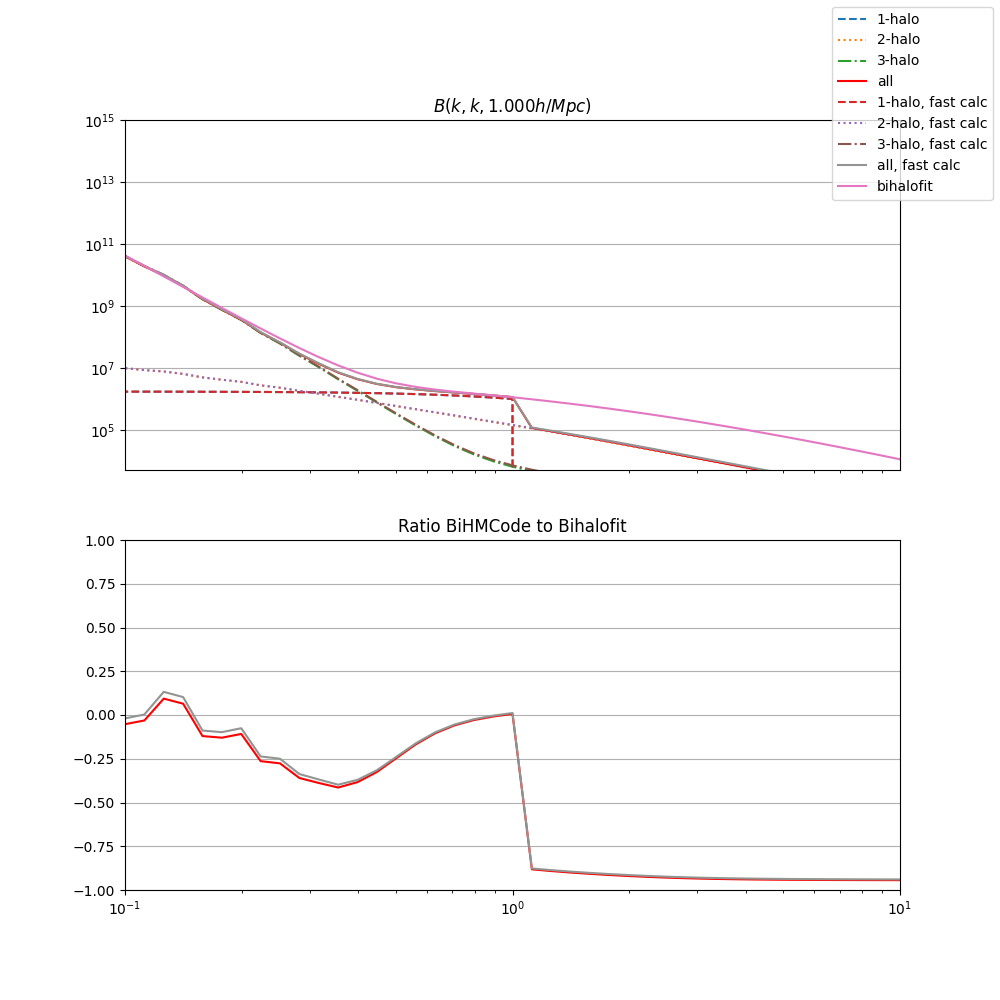

In [18]:
# Plot Bispectrum

fig, axs=plt.subplots(nrows=2, figsize=(10,10))
axs[0].grid(axis='y', which='both')
axs[1].grid(axis='y', which='both')

#fig.subplots_adjust(hspace=0.01)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([])

axs[1].set_ylim(-1, 1)
axs[0].set_ylim(5e3,1e15)
axs[0].set_xlim(0.1, 10)
axs[1].set_xlim(0.1, 10)

axs[0].set_title(r"$B(k,k,$"+f"{ks[0]:.3f}"+"$h/Mpc)$")
Halo1,=axs[0].plot(ks, np.array([result_unequi[2]['m-m-m'][i,0,0] for i in range(len(ks))]), label='1-halo', ls='--')
Halo2,=axs[0].plot(ks, np.array([result_unequi[1]['m-m-m'][i,0,0] for i in range(len(ks))]), label='2-halo', ls=':')
Halo3,=axs[0].plot(ks, np.array([result_unequi[0]['m-m-m'][i,0,0] for i in range(len(ks))]), label='3-halo', ls='-.')
BiHMCode,=axs[0].plot(ks, np.array([result_unequi[3]['m-m-m'][i,0,0] for i in range(len(ks))]), label='all', color='red')

Halo1FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[2]['m-m-m'][i,0,0] for i in range(len(ks))]), label='1-halo, fast calc', ls='--')
Halo2FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[1]['m-m-m'][i,0,0] for i in range(len(ks))]), label='2-halo, fast calc', ls=':')
Halo3FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[0]['m-m-m'][i,0,0] for i in range(len(ks))]), label='3-halo, fast calc', ls='-.')
BiHMCodeFC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,0,0] for i in range(len(ks))]), label='all, fast calc', color='xkcd:grey')

Bihalofit,=axs[0].plot(ks, np.array([bihalofit_bispec_res[i,0,0] for i in range(len(ks))]), label='bihalofit')


axs[1].set_title(r"Ratio BiHMCode to Bihalofit")
Ratio,=axs[1].plot(ks, np.array([result_unequi[3]['m-m-m'][i,0,0]/bihalofit_bispec_res[i,0,0]  for i in range(len(ks))]), color='red')
RatioFC,=axs[1].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,0,0]/bihalofit_bispec_res[i,0,0]  for i in range(len(ks))]), color='xkcd:grey')



fig.legend()


def update(index_k3):
    axs[0].set_title(r"$B(k,k,$"+f"{ks[index_k3]:.3f}"+"$h/Mpc)$")

    Halo1.set_ydata(np.array([result_unequi[2]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo2.set_ydata(np.array([result_unequi[1]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo3.set_ydata(np.array([result_unequi[0]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    BiHMCode.set_ydata(np.array([result_unequi[3]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))

    Halo1FC.set_ydata(np.array([result_unequi_fastCalc[2]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo2FC.set_ydata(np.array([result_unequi_fastCalc[1]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    Halo3FC.set_ydata(np.array([result_unequi_fastCalc[0]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))
    BiHMCodeFC.set_ydata(np.array([result_unequi_fastCalc[3]['m-m-m'][i,i,index_k3] for i in range(len(ks))]))

    Bihalofit.set_ydata(np.array([bihalofit_bispec_res[i,i,index_k3] for i in range(len(ks))]))
    Ratio.set_ydata(np.array([(result_unequi[3]['m-m-m'][i,i,index_k3]-bihalofit_bispec_res[i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])   for i in range(len(ks))]))
    RatioFC.set_ydata(np.array([(result_unequi_fastCalc[3]['m-m-m'][i,i,index_k3]-bihalofit_bispec_res[i,i,index_k3])/(bihalofit_bispec_res[i,i,index_k3])   for i in range(len(ks))]))

    fig.canvas.draw_idle()

interact(update, index_k3=(40, 80))


interactive(children=(IntSlider(value=40, description='ix1', max=80), IntSlider(value=40, description='ix2', m…

<function __main__.update(ix1, ix2)>

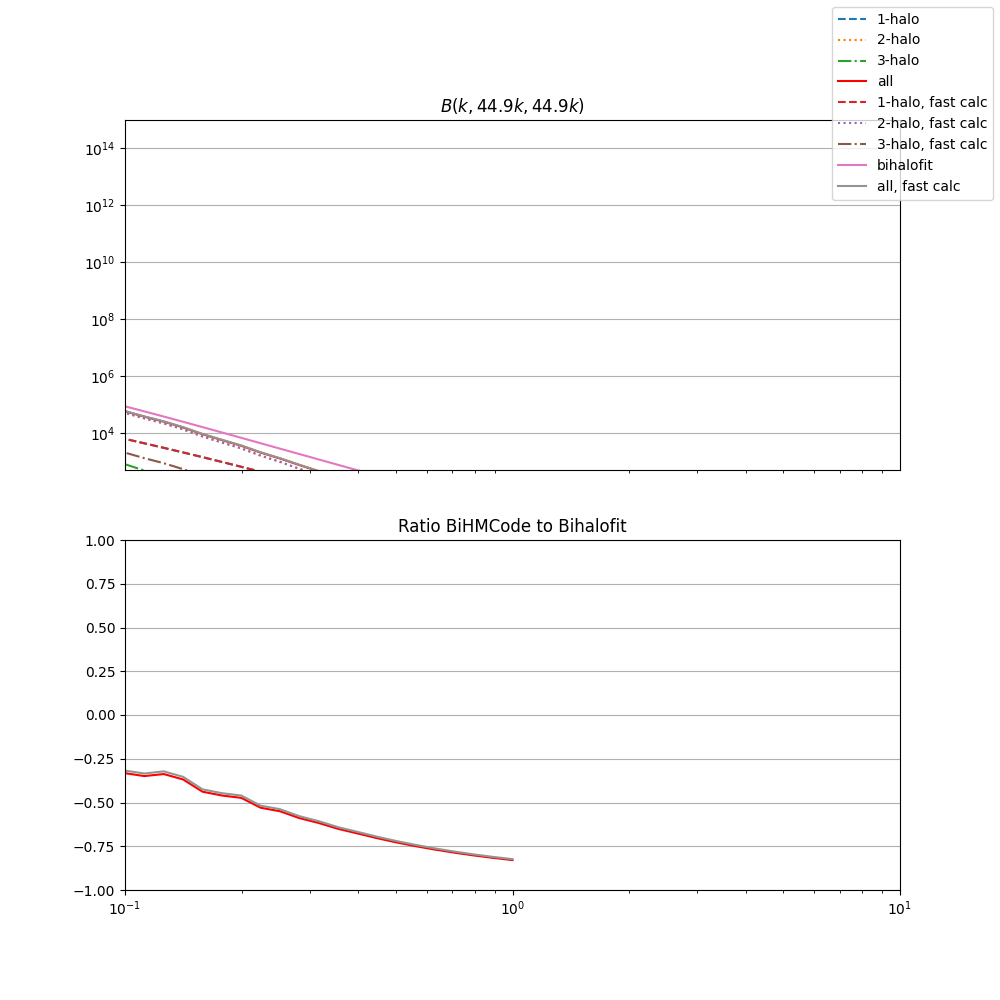

In [19]:
# Plot Bispectrum

fig, axs=plt.subplots(nrows=2, figsize=(10,10))
axs[0].grid(axis='y', which='both')
axs[1].grid(axis='y', which='both')

#fig.subplots_adjust(hspace=0.01)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_xticks([])

axs[1].set_ylim(-1, 1)
axs[0].set_ylim(5e2,1e15)
axs[0].set_xlim(0.1, 10)
axs[1].set_xlim(0.1, 10)

ratio=(ks[1:]/ks[:-1])[0]

axs[0].set_title(r"$B(k,k,k)$")
Halo1,=axs[0].plot(ks, np.array([result_unequi[2]['m-m-m'][i,0,0] for i in range(len(ks))]), label='1-halo', ls='--')
Halo2,=axs[0].plot(ks, np.array([result_unequi[1]['m-m-m'][i,0,0] for i in range(len(ks))]), label='2-halo', ls=':')
Halo3,=axs[0].plot(ks, np.array([result_unequi[0]['m-m-m'][i,0,0] for i in range(len(ks))]), label='3-halo', ls='-.')
BiHMCode,=axs[0].plot(ks, np.array([result_unequi[3]['m-m-m'][i,0,0] for i in range(len(ks))]), label='all', color='red')



Halo1FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[2]['m-m-m'][i,0,0] for i in range(len(ks))]), label='1-halo, fast calc', ls='--')
Halo2FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[1]['m-m-m'][i,0,0] for i in range(len(ks))]), label='2-halo, fast calc', ls=':')
Halo3FC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[0]['m-m-m'][i,0,0] for i in range(len(ks))]), label='3-halo, fast calc', ls='-.')

Bihalofit,=axs[0].plot(ks, np.array([bihalofit_bispec_res[i,0,0] for i in range(len(ks))]), label='bihalofit')
BiHMCodeFC,=axs[0].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,0,0] for i in range(len(ks))]), label='all, fast calc', color='xkcd:grey')

axs[1].set_title(r"Ratio BiHMCode to Bihalofit")
Ratio,=axs[1].plot(ks, np.array([result_unequi[3]['m-m-m'][i,0,0]/bihalofit_bispec_res[i,0,0]  for i in range(len(ks))]), color='red')
RatioFC,=axs[1].plot(ks, np.array([result_unequi_fastCalc[3]['m-m-m'][i,0,0]/bihalofit_bispec_res[i,0,0]  for i in range(len(ks))]), color='xkcd:grey')


fig.legend()


def update(ix1, ix2):
    if ix1==0 and ix2==0:
        axs[0].set_title(r"$B(k,k,k)$")
    elif ix1==0:
        axs[0].set_title(r"$B(k,k,$"+f"{ratio*ix2:.1f}"+"$k)$")
    elif ix2==0:
        axs[0].set_title(r"$B(k,$"+f"{ratio*ix1:.1f}"+"$k,k)$")
    else:
        axs[0].set_title(r"$B(k,$"+f"{ratio*ix1:.1f}"+"$k,$"+f"{ratio*ix2:.1f}"+"$k)$")
    print(ix1, ix2, max(ix1,ix2))
    Halo1.set_ydata(np.array([result_unequi[2]['m-m-m'][i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    Halo1.set_xdata(ks[:len(ks)-max(ix1,ix2)])
  
    Halo2.set_ydata(np.array([result_unequi[1]['m-m-m'][i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    Halo2.set_xdata(ks[:len(ks)-max(ix1, ix2)])
    Halo3.set_ydata(np.array([result_unequi[0]['m-m-m'][i,i+ix1, i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    Halo3.set_xdata(ks[:len(ks)-max(ix1, ix2)])




    Halo1FC.set_ydata(np.array([result_unequi_fastCalc[2]['m-m-m'][i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    Halo1FC.set_xdata(ks[:len(ks)-max(ix1,ix2)])

    Halo2FC.set_ydata(np.array([result_unequi_fastCalc[1]['m-m-m'][i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    Halo2FC.set_xdata(ks[:len(ks)-max(ix1,ix2)])

    Halo3FC.set_ydata(np.array([result_unequi_fastCalc[0]['m-m-m'][i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    Halo3FC.set_xdata(ks[:len(ks)-max(ix1,ix2)])

    BiHMCode.set_ydata(np.array([result_unequi[3]['m-m-m'][i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    BiHMCode.set_xdata(ks[:len(ks)-max(ix1, ix2)])

    BiHMCodeFC.set_ydata(np.array([result_unequi_fastCalc[3]['m-m-m'][i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    BiHMCodeFC.set_xdata(ks[:len(ks)-max(ix1,ix2)])



    Bihalofit.set_ydata(np.array([bihalofit_bispec_res[i,i+ix1,i+ix2] for i in range(len(ks)-max(ix1, ix2))]))
    Bihalofit.set_xdata(ks[:len(ks)-max(ix1, ix2)])

    Ratio.set_ydata(np.array([(result_unequi[3]['m-m-m'][i,i+ix1,i+ix2]-bihalofit_bispec_res[i,i+ix1,i+ix2])/(bihalofit_bispec_res[i,i+ix1,i+ix2])   for i in range(len(ks)-max(ix1, ix2))]))
    Ratio.set_xdata(ks[:len(ks)-max(ix1, ix2)])

    RatioFC.set_ydata(np.array([(result_unequi_fastCalc[3]['m-m-m'][i,i+ix1, i+ix2]-bihalofit_bispec_res[i,i+ix1,i+ix2])/(bihalofit_bispec_res[i,i+ix1,i+ix2])   for i in range(len(ks)-max(ix1, ix2))]))
    RatioFC.set_xdata(ks[:len(ks)-max(ix1,ix2)])



    fig.canvas.draw_idle()

interact(update, ix1=(0, 80), ix2=(0,80))
